In [9]:
import torch
import string
from io import open
import unicodedata
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import string
import time

In [434]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )
char_set = set()
with open('small.txt', 'r') as file:
            for line in file:
                for i in range(len(line)):
                    char_set.add(line[i])
extras = string.ascii_letters + ".,:'0123456789"
chars = ""

for i in range(len(extras)):
    char_set.add(extras[i])
    
for letter in char_set:
    chars += letter

                    
allowed_characters = chars

n_letters = len(allowed_characters)
print(n_letters)
def letterToIndex(letter):
    return allowed_characters.find(letter)


def lineToTensor(line):
    line = unicodeToAscii(line)
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)



97


In [436]:
class TextDataset(Dataset):

    def __init__(self, filename):
        self.load_time = time.localtime
        labels_set = set()
        self.filename = filename

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []


        with open(filename, 'r') as file:
            for line in file:
                line = line.strip().split('\t')
                
                self.data.append(line[0])
                self.data.append(line[1])
                self.data_tensors.append(lineToTensor(line[0]))
                self.data_tensors.append(lineToTensor(line[1]))

                self.labels.append('A')
                self.labels.append('B')

        labels_set.add('A')
        labels_set.add('B')
        self.labels_uniq = list(labels_set)
        # Creates a list of tensor labels, one for each data tensor. 
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], 
            dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
            return len(self.data)
        
    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item
    

In [438]:


filename = 'small.txt'
data_set = TextDataset(filename)

train_set, test_set = torch.utils.data.random_split(data_set, [.85, .15], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 1700, validation examples = 300


In [442]:
import torch.nn as nn
import torch.nn.functional as F


In [444]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0])
        output = self.softmax(output)

        return output

In [446]:
n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, len(data_set.labels_uniq))
print(rnn)

CharRNN(
  (rnn): RNN(97, 128)
  (h2o): Linear(in_features=128, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [448]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

In [450]:
import random
import numpy as np


In [452]:
def train(rnn, training_data, n_epoch = 10, n_batch_size = 64, report_every = 50, learning_rate = 0.2, criterion = nn.NLLLoss()):
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds
    """
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    start = time.time()
    print(f"training on data set with n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad() # clear the gradients

        # create some minibatches
        # we cannot use dataloaders because each of our names is a different length
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) //n_batch_size )

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch: #for each example in this batch
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            # optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches) )
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses

In [454]:
start = time.time()
all_losses = train(rnn, train_set, n_epoch=27, learning_rate=0.30, report_every=1)
end = time.time()
print(f"training took {end-start}s")

training on data set with n = 1700
1 (4%): 	 average batch loss = 0.9774202187086534
2 (7%): 	 average batch loss = 2.3060521017207627
3 (11%): 	 average batch loss = 2.7349215286744633
4 (15%): 	 average batch loss = 2.815400856165811
5 (19%): 	 average batch loss = 1.7744065552004054
6 (22%): 	 average batch loss = 1.5760199816825033
7 (26%): 	 average batch loss = 3.4366920712303255
8 (30%): 	 average batch loss = 2.4360463708580364
9 (33%): 	 average batch loss = 2.8450088926427832
10 (37%): 	 average batch loss = 1.7346863096325078
11 (41%): 	 average batch loss = 2.074778377272353
12 (44%): 	 average batch loss = 2.143980283636292
13 (48%): 	 average batch loss = 1.7509391258325933
14 (52%): 	 average batch loss = 1.947639126954635
15 (56%): 	 average batch loss = 2.1563340046680675
16 (59%): 	 average batch loss = 2.0075365034038075
17 (63%): 	 average batch loss = 2.052566726818635
18 (67%): 	 average batch loss = 2.195920034281686
19 (70%): 	 average batch loss = 2.23001369321

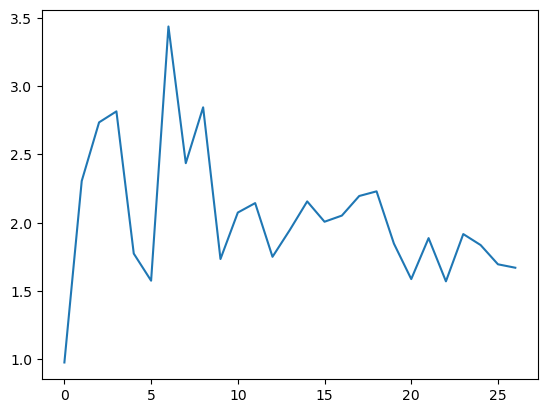

In [456]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()


In [464]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i


def evaluate(rnn, testing_data, classes):

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        total = 0
        correct = 0
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            if (guess == label):
                correct += 1
            total += 1
            
        ratio = correct / total
        print(ratio)
                




test_set = TextDataset('small.txt')
evaluate(rnn, test_set, classes=data_set.labels_uniq)

0.49645


In [476]:
with open('mini.txt', 'r') as file:
        for line in file:
            line = line.strip().split('\t')
            if len(line[0]) >= len(line[1]):
                new_string = ""
                for i in range(len(line[1])):
                    if line[0][i] == line[1][i]:
                        new_string += " "
                    else: 
                        new_string += line[1][i]
                print(new_string)


                                                                             , journey                                                                           
                                                                                                                                           wd                                                                                                                                                                                                                                            
                                                                                          in school                 
                        hg                 
                                                    L nd   to l ok for Diana .
                                                                                                                                                               in East settlement policy           
                        